# Formalia:

Please read the [assignment overview page](https://github.com/suneman/socialgraphs2025/wiki/Assignments) carefully before proceeding. This page contains information about formatting (including formats etc), group sizes, and many other aspects of handing in the assignment. 

_If you fail to follow these simple instructions, it will negatively impact your grade!_

**Due date and time**: The assignment is due on Tuesday September 30th, 2025 at 23:55. Hand in your IPython notebook file (with extension `.ipynb`) via DTU Learn

# Assignment 1.1: Exploring WS and BA models

This first part draws on the Watts-Stogatz and Barabasi-Albert models from Week 3. You should provide solutions to the exercises with the following titles from **Part 1** 

* *Did you really read the text? Answer the following questions (no calculations needed) in your IPython notebook*

* *WS edition*

And from **Part 2**

* *BA Edition*.
  * **Note**: The second part of this exercise (after the questions to the text) first has you build a BA network step-by-step, but doesn't ask any questions. For that part, I would simply like you to write well-documented code that shows how you build the network. 


# Assignment 1.2: Stats and visualization of the Rock Music Network

This second part requires you to have built the network of Rock Musicians as described in the exercises for Week 4. You should complete the following exercise from **Part 2**.

* *Explain your process in words*

* *Simple network statistics and analysis*.

  * **Note related to this and the following exercise**. It is nice to have the dataset underlying the statistics and visualization available when we grade. Therefore, I recommend that you create a small *network dataset*, which is simply your graph stored in some format that you like (since it's only a few hundred nodes and a few thousand edges, it won't take up a lot of space). You can then place that network one of your group members' GitHub account (or some other server that's available online) and have your Jupyter Notebook fetch that dataset when it runs. (It's OK to use an LLM for help with setting this up, if it seems difficult). 

And the following exercise from **Part 3**

* *Let's build a simple visualization of the network*

And that's it! You're all set.

### 1.2 PART 2 - Explain process in words

The first thing that we did was to trying to understand how Wikipedia stored links inside pages and we played a bit for understanding how to extract single performer names from the List of mainstream rock performers provided using RegEx.

When we understood how to do it, with a function we extracted all the names of the page, ending up with 490 titles, with also a sanity check for veryfing that any other title (for examples reference links) ended up in our list.

Then we have set up a function that, for every performer title found, call the endpoint of Wikipedia API in order to get the cleanest source text for each performer's page (link-parking would have been easier).
We downloaded as wikitext since keeps internal links perfectly for then parsing with RegEx and saved as one .txt per title.

Then, at this point, we had all the elements needed for building the network: each performer bacame a not and every performer page has been parsed with a regex to extract outgoing kinks; if a link pointed to another performer in my set we added a directed edge A->B. Then we computed a word count from the cleaned wikitext and stored it as a content_length attribute on each node. This can be used as a metric for how much information exists about a performer and and we hoped then to can correlate this to the number of outgoing/ingoing edges.

Finally we removed isolated nodes (no in- or out-links), then kept the largest weakly connected component (LWCC) for analysis.

The hardest part was to correctly extract and filter the links. Wikipedia pages are full of internal references, so it was still necessary to ignore links belonging to other namespaces such as Category: or File:, and to double-check that the links we kept really matched one of our performers. 
We used LLM mostly as a way to create the pipeline and to test whether regexes and API calls were set up in a robust way. Once I had these suggestions, I always verified them manually on a few performer pages, adjusted when needed, and only then scaled up the process.

We don't really know what we would change if we would need to do it again, maybe inspecting other types of parser which would make link extraction and text cleaning more robust. 

### PART 2 - Simple network statistics and analysis

In [26]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

nodes = pd.read_csv("https://raw.githubusercontent.com/lovomanuel/sgi/main/rock_data/nodes.csv")
edges = pd.read_csv("https://raw.githubusercontent.com/lovomanuel/sgi/main/rock_data/edges.csv")

G = nx.DiGraph()
for _, row in nodes.iterrows():
    G.add_node(row["id"], content_length=int(row["content_length"]))

for _, row in edges.iterrows():
    G.add_edge(row["source"], row["target"])

In [27]:
N = G.number_of_nodes()
M = G.number_of_edges()
print("Nodes:", N)
print("Links:", M)

isolates = [n for n, d in G.degree() if d == 0]
print("Number of isolates:", len(isolates))

num_wcc = nx.number_weakly_connected_components(G)
print("Weakly connected components:", num_wcc)   


Nodes: 490
Links: 7305
Number of isolates: 0
Weakly connected components: 1


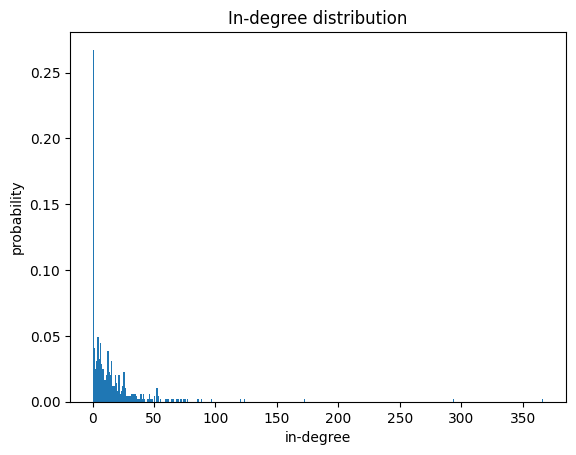

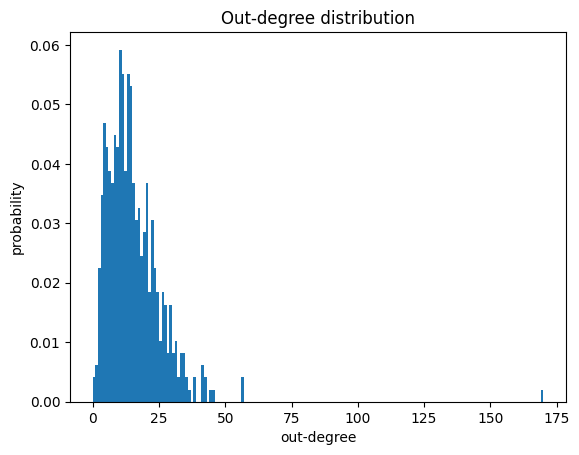

In [28]:
in_deg  = [d for _, d in G.in_degree()]
out_deg = [d for _, d in G.out_degree()]

plt.figure()
plt.hist(in_deg, bins=range(0, max(in_deg)+2), density=True)
plt.title("In-degree distribution")
plt.xlabel("in-degree"); plt.ylabel("probability")
plt.show()

plt.figure()
plt.hist(out_deg, bins=range(0, max(out_deg)+2), density=True)
plt.title("Out-degree distribution")
plt.xlabel("out-degree"); plt.ylabel("probability")
plt.show()

We can see from the out-degree plot that most nodes have a small number of outgoing links and that there is a long tail (some performer's pages link to a lot). Overall shape looks skewed but not extremely.
For what regards in-degree distribution there is a spike at 0, meaning that many performers are not linked to by others; moreover there is a long heavy tail, meaning that some performers get referenced by a large number of others.

The difference between those two are given by the fact that out-degree is limited by how many links editors choose to add on a single page, while in-degree can grow without bound as many different pages link to the same popular performer.

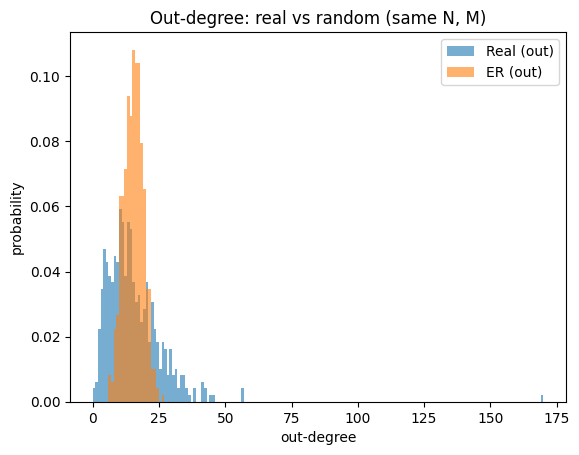

In [29]:
ER = nx.gnm_random_graph(N, M, directed=True, seed=42)
er_out = [d for _, d in ER.out_degree()]

mx = max(out_deg + er_out) if (out_deg and er_out) else 0
bins = range(0, mx+2)

plt.figure()
plt.hist(out_deg, bins=bins, density=True, alpha=0.6, label="Real (out)")
plt.hist(er_out, bins=bins, density=True, alpha=0.6, label="ER (out)")
plt.title("Out-degree: real vs random (same N, M)")
plt.xlabel("out-degree"); plt.ylabel("probability")
plt.legend()
plt.show()

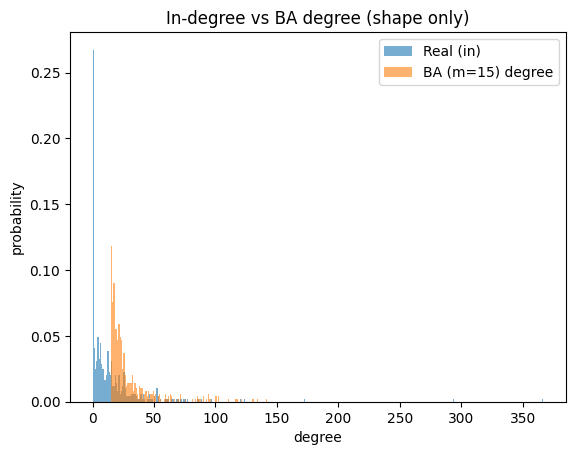

In [30]:
m = max(1, round(M / N)) if N > 0 else 1
BA = nx.barabasi_albert_graph(N, m, seed=42)
ba_deg = [d for _, d in BA.degree()]

mx = max(in_deg + ba_deg) if (in_deg and ba_deg) else 0
bins = range(0, mx+2)

plt.figure()
plt.hist(in_deg, bins=bins, density=True, alpha=0.6, label="Real (in)")
plt.hist(ba_deg, bins=bins, density=True, alpha=0.6, label=f"BA (m={m}) degree")
plt.title("In-degree vs BA degree (shape only)")
plt.xlabel("degree"); plt.ylabel("probability")
plt.legend()
plt.show()

In [31]:
top_in  = sorted(G.in_degree(),  key=lambda x: x[1], reverse=True)[:5]
top_out = sorted(G.out_degree(), key=lambda x: x[1], reverse=True)[:5]

print("\nTop 5 by IN-degree:")
for n, d in top_in:
    print(f"{n}: {d}")

print("\nTop 5 by OUT-degree:")
for n, d in top_out:
    print(f"{n}: {d}")


Top 5 by IN-degree:
AllMusic: 366
Rock music: 293
The Beatles: 172
The Rolling Stones: 123
Led Zeppelin: 120

Top 5 by OUT-degree:
Rock music: 169
Alice in Chains: 56
Deep Purple: 56
Bryan Adams: 45
Guns N Roses: 44


The performers with the highest in-degree are AllMusic (366), Rock music (293), The Beatles (172), The Rolling Stones (123), and Led Zeppelin (120). This means many other pages link to them, which makes sense: the general pages (AllMusic and Rock music) act like hubs, and the globally famous bands (Beatles, Stones, Zeppelin) are natural reference points.

The performers with the highest out-degree are Rock music (169), Alice in Chains (56), Deep Purple (56), Bryan Adams (45), and Guns N’ Roses (44). These are the pages that link out to many others, often because they contain long lists of influences, collaborations, or band members.

This pattern is what I expected: the most iconic bands attract lots of incoming links. The presence of generic hub pages (AllMusic, Rock music) at the top also highlights that not all “nodes” in the dataset are single bands.

In [32]:
longest = sorted(G.nodes(), key=lambda n: G.nodes[n].get("content_length", 0), reverse=True)[:10]
print("\nTop 10 by content_length:")
for n in longest:
    print(f"{n}: {G.nodes[n].get('content_length', 0)}")



Top 10 by content_length:
The Beatles: 14296
Paul McCartney: 14118
David Bowie: 13456
Bob Dylan: 13052
John Lennon: 12878
Pink Floyd: 12167
The Beach Boys: 12148
The Rolling Stones: 12000
Queen band: 11931
ABBA: 11922


### 1.2 - PART 3

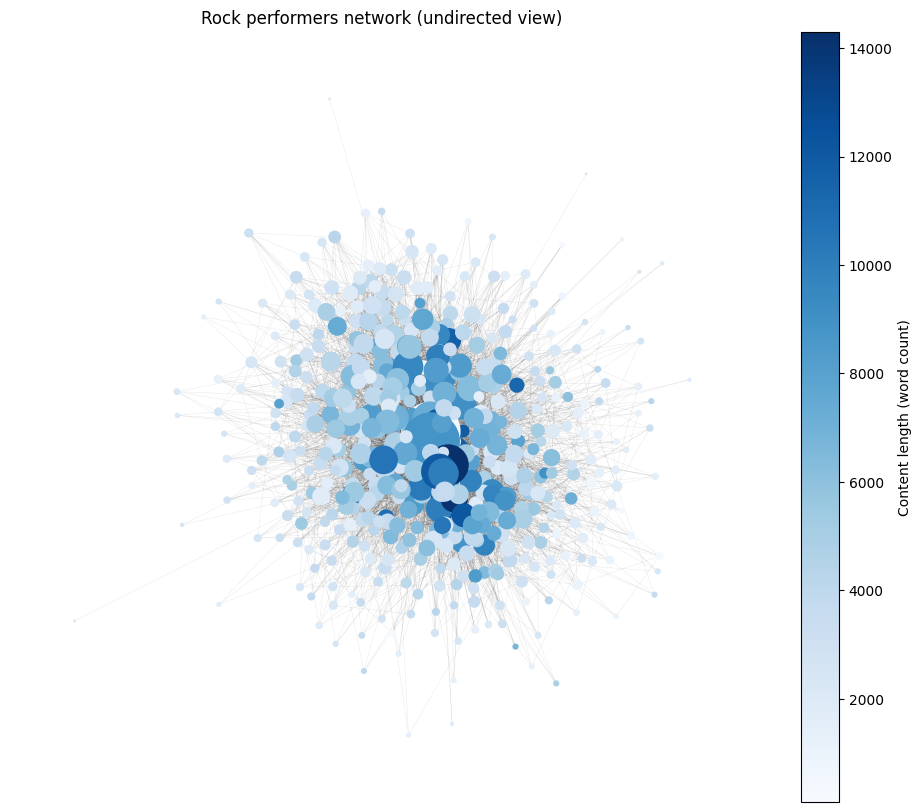

In [33]:
from matplotlib import cm

# G = your directed graph from before
UG = G.to_undirected()   # undirected copy just for visualization

# node size = degree (undirected degree since we converted)
deg = dict(UG.degree())
sizes = [deg[n] * 5 for n in UG.nodes()]  # adjust multiplier for visibility

# node color = content_length (with a simple sequential colormap)
cl = [UG.nodes[n].get("content_length", 0) for n in UG.nodes()]
cmap = plt.cm.Blues

# layout
pos = nx.spring_layout(UG, seed=42)   # or nx.kamada_kawai_layout(UG)

plt.figure(figsize=(12, 10))
nx.draw_networkx_edges(UG, pos, alpha=0.1, width=0.3)
nodes = nx.draw_networkx_nodes(
    UG, pos,
    node_size=sizes,
    node_color=cl,
    cmap=cmap,
    linewidths=0
)

# add colorbar
cbar = plt.colorbar(nodes)
cbar.set_label("Content length (word count)")

plt.title("Rock performers network (undirected view)")
plt.axis("off")
plt.show()